In [2]:
import tensorflow as tf

In [3]:
!find /home/teaching/Atmega_MIC/DP\ Students/Abhay/cropwise_data/apple -type d -name ".ipynb_checkpoints" -exec rm -r {} +


In [5]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/apple"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 40462 files belonging to 8 classes.


In [6]:
classes = training_set.class_names

In [7]:
classes

['apple_black_rot',
 'apple_cedar_apple_rust',
 'apple_complex',
 'apple_frog_eye_leaf_spot',
 'apple_healthy',
 'apple_powdery_mildew',
 'apple_rust',
 'apple_scab']

In [8]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size

In [9]:
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)


In [10]:
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

1265
1012
253


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [12]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [13]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/10
1012/1012 [==============================] - 257s 252ms/step - loss: 0.6590 - categorical_accuracy: 0.7787 - val_loss: 0.4310 - val_categorical_accuracy: 0.8538 - lr: 1.0000e-04
Epoch 2/10
1012/1012 [==============================] - 277s 273ms/step - loss: 0.3909 - categorical_accuracy: 0.8699 - val_loss: 0.3751 - val_categorical_accuracy: 0.8745 - lr: 1.0000e-04
Epoch 3/10
1012/1012 [==============================] - 300s 295ms/step - loss: 0.3475 - categorical_accuracy: 0.8822 - val_loss: 0.3504 - val_categorical_accuracy: 0.8818 - lr: 1.0000e-04
Epoch 4/10
1012/1012 [==============================] - 255s 252ms/step - loss: 0.3213 - categorical_accuracy: 0.8913 - val_loss: 0.3446 - val_categorical_accuracy: 0.8838 - lr: 1.0000e-04
Epoch 5/10
1012/1012 [==============================] - 253s 250ms/step - loss: 0.3018 - categorical_accuracy: 0.8968 - val_loss: 0.3303 - val_categorical_accuracy: 0.8888 - lr: 1.0000e-04
Epoch 6/10
1012/1012 [==============================] -

In [15]:
train_loss,train_acc = model.evaluate(train_ds)

1012/1012 [==============================] - 170s 167ms/step - loss: 0.2398 - categorical_accuracy: 0.9158


In [16]:
print(train_loss,train_acc)

0.23979052901268005 0.9157917499542236


In [17]:
model.save("trained_model_apple.keras")

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

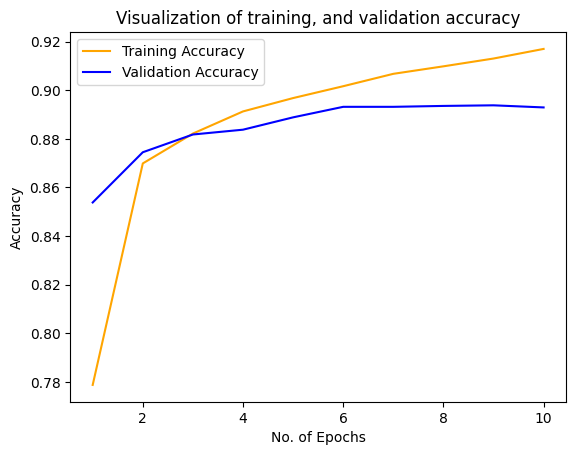

In [19]:
epochs=[i for i in range(1,11)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()


In [20]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions)]

    print(f"Predicted class: {predicted_class}")
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np

1/1 [==============================] - 0s 22ms/step
Predicted class: apple_rust


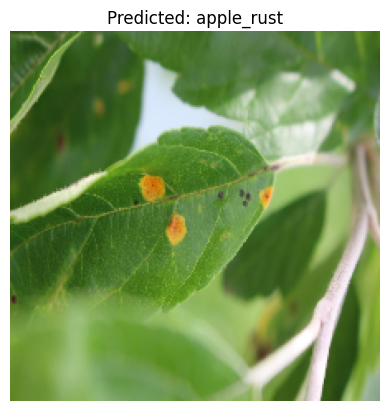

In [23]:
predict_image("/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/apple/apple_rust/FGVC7 Train_31.jpg")